In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from utility import load_dataset

### Loading Dataset

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

y = 0. It's a non-cat picture.


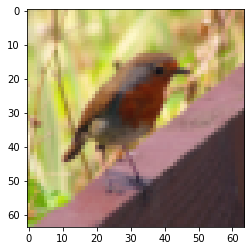

In [3]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

Getting Shapes of Data

In [4]:
print('train_x_shape :',train_x_orig.shape)
print('train_y_shape :',train_y.shape)
print('test_x_shape  :',test_x_orig.shape)
print('test_y_shape  :',test_y.shape)
print('Classes       :',classes)

train_x_shape : (209, 64, 64, 3)
train_y_shape : (1, 209)
test_x_shape  : (50, 64, 64, 3)
test_y_shape  : (1, 50)
Classes       : [b'non-cat' b'cat']


Getting necessary variables

In [5]:
m_train = train_x_orig.shape[0]
m_test  = test_x_orig.shape[0]
num_px  = train_x_orig.shape[1]

#### Reshaping Data

In [6]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

In [7]:
print('train_x_flatten :',train_x_flatten.shape)
print('test_x_flatten  :',test_x_flatten.shape)

train_x_flatten : (12288, 209)
test_x_flatten  : (12288, 50)


#### Preprocessing Data

In [8]:
# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

###  Creating placeholders
Your first task is to create placeholders for `X` and `Y`. This will allow you to later pass your training data in when you run your session. 


In [9]:
def create_placeholders(n_x,n_y):
    
    X = tf.placeholder(tf.float32,[n_x,None],name='x')
    Y = tf.placeholder(tf.float32,[n_y,None],name='y')
    
    return X,Y

In [10]:
X, Y = create_placeholders(12288, 1)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("x:0", shape=(12288, ?), dtype=float32)
Y = Tensor("y:0", shape=(1, ?), dtype=float32)


### Initialize Parameters

In [11]:
def initialize():
    
    W1 = tf.get_variable('W1',[7,12288],initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable('b1',[7,1],initializer = tf.zeros_initializer())
    W2 = tf.get_variable('W2',[1,7],initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable('b2',[1,1],initializer = tf.zeros_initializer())
    
    parameters = {'W1':W1,'b1':b1,'W2':W2,'b2':b2}
    
    return parameters

### Forward propagation

In [12]:
def forward_propagation(X,parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    
    return Z2


In [13]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 1)
    parameters = initialize()
    Z2 = forward_propagation(X, parameters)
    print("Z2 = " + str(Z2))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Z2 = Tensor("Add_1:0", shape=(1, ?), dtype=float32)


### Compute Cost

You can also use a built-in function to compute the cost of your neural network. So instead of needing to write code to compute this as a function of $a^{[2](i)}$ and $y^{(i)}$ for i=1...m: 
$$ J = - \frac{1}{m}  \sum_{i = 1}^m  \large ( \small y^{(i)} \log a^{ [2] (i)} + (1-y^{(i)})\log (1-a^{ [2] (i)} )\large )\small\tag{2}$$

you can do it in one line of code in tensorflow!

Implement the cross entropy loss. The function you will use is: 


- `tf.nn.sigmoid_cross_entropy_with_logits(logits = ...,  labels = ...)`

Your code should input `z`, compute the sigmoid (to get `a`) and then compute the cross entropy cost $J$. All this can be done using one call to `tf.nn.sigmoid_cross_entropy_with_logits`, which computes

$$- \frac{1}{m}  \sum_{i = 1}^m  \large ( \small y^{(i)} \log \sigma(z^{[2](i)}) + (1-y^{(i)})\log (1-\sigma(z^{[2](i)})\large )\small\tag{2}$$



In [14]:
def compute_cost(Z2,Y):
    
    logits = tf.transpose(Z2)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [15]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(12288, 1)
    parameters = initialize()
    Z2 = forward_propagation(X, parameters)
    cost = compute_cost(Z2, Y)
    print("cost = " + str(cost))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
cost = Tensor("Mean:0", shape=(), dtype=float32)


### Backprop

In [16]:
def model(X_train,Y_train,learning_rate,iterations):
    
    ops.reset_default_graph()
    
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    
    X, Y = create_placeholders(n_x,n_y)
    
    parameters = initialize()
    
    Z3 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        #run initialization
        sess.run(init)
        
        for i in range(iterations):
            sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})
            
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        
    return parameters

In [17]:
import time

In [18]:
tic = time.time()
final_parameters = model(train_x,train_y,learning_rate=0.0075,iterations=2500)
toc = time.time()

print('Training time : ',toc-tic,'seconds')

Training time :  47.59463930130005 seconds


### Getting A2

In [19]:
def forward_prop_test(X,parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2}
    x = tf.placeholder("float", [12288, None])
    
    z2 = forward_propagation(x,params)
    A2 = tf.sigmoid(z2)
    sess = tf.Session()
    Z2 = sess.run(A2,feed_dict={x:X})
    sess.close()
    return Z2

In [20]:
A2 = forward_prop_test(test_x,final_parameters)
print(A2)

[[9.8577142e-01 5.4266679e-01 8.8235241e-01 4.6873543e-01 8.4932435e-01
  6.6639483e-02 1.2253523e-03 9.8567438e-01 9.9870449e-01 6.1133486e-01
  9.9729884e-01 5.2396894e-01 9.9851656e-01 6.1133486e-01 2.9811263e-04
  9.3214452e-01 4.9718827e-02 6.1092067e-01 7.5541139e-02 1.1107624e-03
  9.1494542e-01 3.2222599e-02 9.2089176e-06 4.4630882e-01 9.5721865e-01
  9.5151508e-01 1.9883358e-01 1.1367202e-03 3.0514717e-02 3.4902662e-01
  9.5478505e-01 9.9922025e-01 9.8850656e-01 1.7818135e-01 1.8221515e-01
  1.0130703e-03 2.9254675e-02 5.1449990e-01 2.9757500e-02 3.6260486e-04
  2.9486805e-01 4.1312265e-01 1.2777296e-01 8.2406402e-03 9.8768479e-01
  8.2044947e-01 3.4230998e-01 9.5306718e-01 5.1577306e-01 2.2620996e-03]]


In [21]:
for i in range(50):
    if(A2[0][i]>0.5):
        A2[0][i]=1
    else:
        A2[0][i]=0
print(A2)

[[1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.
  1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.
  1. 0.]]


In [22]:
print(test_y)

[[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0
  0 1 0 0 1 1 1 0 0 0 1 1 1 0]]


### Getting Accuracy

In [23]:
c = 0
for i in range(50):
    if(A2[0][i]==test_y[0][i]):
        c+=1
print('Accuracy :' ,(c/50)*100,'%')

Accuracy : 70.0 %
